In [ ]:
from __future__ import print_function

import os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

import keras
from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [ ]:
# defining the key parameters
batch_size = 100
original_dim = 784
intermediate_dim = 256
latent_dim = 2
epochs = 30
epsilon_std = 1.0

In [ ]:
print(f'tensorflow version = {tf.__version__}')
print(f'keras version = {keras.__version__}')

# Countermeasures for version inconsistencies
tf.compat.v1.disable_eager_execution()

tensorflow version = 2.7.0
keras version = 2.7.0


In [ ]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [ ]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
# (note) z = encoder(x)[2]
#
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
print(F'x_train.shape {x_train.shape}')
print(F'x_test.shape {x_test.shape}')
print(F'y_train.shape {y_train.shape}')
print(F'y_test.shape {y_test.shape}')

#print(F'x_train {x_train[0:10][0:10]}')
print(F'y_train {y_train[0:10]}')

x_train.shape (60000, 784)
x_test.shape (10000, 784)
y_train.shape (60000,)
y_test.shape (10000,)
y_train [5 0 4 1 9 2 1 3 1 4]


In [ ]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs, 
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 139us/sample - loss: 151.1155
Epoch 2/30
60000/60000 [==============================] - 8s 139us/sample - loss: 150.9592
Epoch 3/30
60000/60000 [==============================] - 8s 139us/sample - loss: 150.8150
Epoch 4/30
60000/60000 [==============================] - 8s 139us/sample - loss: 150.6524
Epoch 5/30
60000/60000 [==============================] - 8s 140us/sample - loss: 150.5127
Epoch 6/30
60000/60000 [==============================] - 8s 141us/sample - loss: 150.4005
Epoch 7/30
60000/60000 [==============================] - 8s 142us/sample - loss: 150.2336
Epoch 8/30
60000/60000 [==============================] - 8s 141us/sample - loss: 150.1638
Epoch 9/30
60000/60000 [==============================] - 8s 141us/sample - loss: 150.0012
Epoch 10/30
60000/60000 [==============================] - 9s 142us/sample - loss: 149.8859
Epoch 11/30
60000/60000 [==============================] - 8s 141u

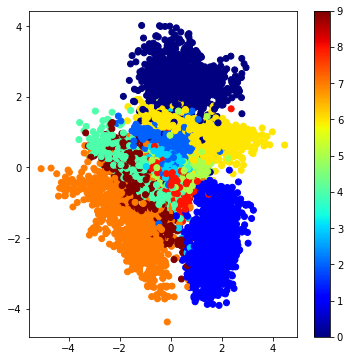

In [ ]:
# display a 2D plot of the digit classes in the latent space (mean)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

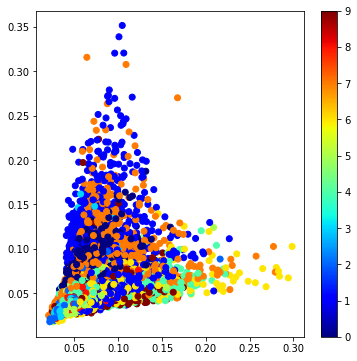

In [ ]:
# display a 2D plot of the digit classes in the latent space  (SD)
x_test_encoded_SD = np.sqrt(np.exp(encoder.predict(x_test, batch_size=batch_size)[1]))
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded_SD[:,0], x_test_encoded_SD[:,1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

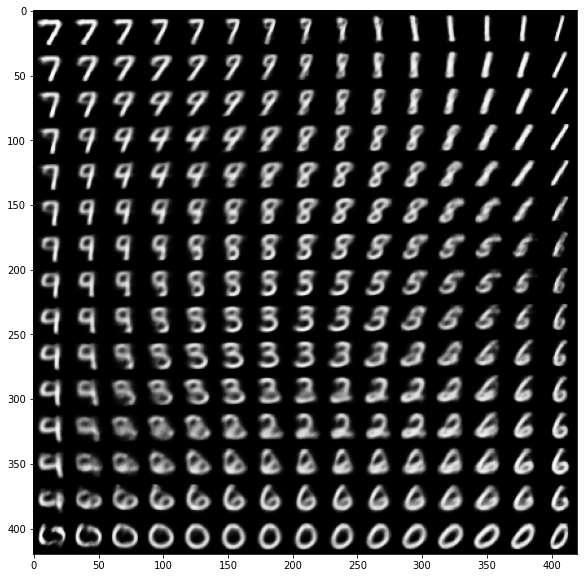

grid_x [-2.32634787e+00 -1.40507156e+00 -1.03643339e+00 -7.72193214e-01
 -5.53384720e-01 -3.58458793e-01 -1.76374165e-01 -1.39145821e-16
  1.76374165e-01  3.58458793e-01  5.53384720e-01  7.72193214e-01
  1.03643339e+00  1.40507156e+00  2.32634787e+00]


In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

print(f'grid_x {grid_x}')

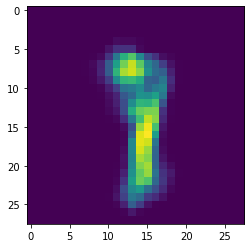

In [ ]:
sample_vector = np.array([[0.2,-2.8]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped= decoded_example.reshape(28,28)
plt.imshow(decoded_example_reshaped)
plt.show()